In [230]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from pyclustering.cluster.clarans import clarans
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# Adjusting for Data Frame Output
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

In [231]:
# Categorical feature need to change numeric
# Encoder
def object_encoder(dataframe, encoder, target_feature):
    # For LabelEncoder
    if encoder == "LabelEncoder" or encoder == "LabelEncoder()":
        encoder = LabelEncoder()
        for target in target_feature:
            dataframe[target] = encoder.fit_transform(dataframe[target])

    # For Ordinal Encoder
    elif encoder == "OrdinalEncoder" or encoder == "OrdinalEncoder()":
        encoder = OrdinalEncoder()
        encoder.fit(dataframe[target_feature])
        dataframe[target_feature] = encoder.transform(dataframe[target_feature])

    # For encoder is None
    elif encoder is None:
        return dataframe

    # Returns None for error message output if not the above 3 types of values
    else:
        return None

    return dataframe

In [232]:
# Scaling
def data_scaling(dataframe, scaling):
    # Perform scaling according to the scaler, respectively
    if scaling == "StandardScaler" or scaling == "StandardScaler()":
        scaling = StandardScaler()
    elif scaling == "MinMaxScaler" or scaling == "MinMaxScaler()":
        scaling = MinMaxScaler()
    elif scaling == "MaxAbsScaler" or scaling == "MaxAbsScaler()":
        scaling = MaxAbsScaler()
    elif scaling == "RobustScaler" or scaling == "RobustScaler()":
        scaling = RobustScaler()
    elif scaling == "Normalizer" or scaling == "Normalizer()":
        scaling = Normalizer()
    elif scaling is None:
        return dataframe

    # Returns None for error message output if not the above 6 types of values
    else:
        return None

    dataframe = pd.DataFrame(scaling.fit_transform(dataframe), columns=dataframe.columns)
    return dataframe

In [233]:
# K-means
def model_kmeans(dataset, real_result, clusters_list=None):
    # Parameters
    if clusters_list is None:
        clusters_list = [2, 4, 6, 8, 10]  # count of clustering
    n_init_list = [10, 20, 30]  # n_init list
    algorithm_list = ["auto", "full", "elkan"]  # algorithm list

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    # Set to generate subplot according to the number of parameters
    row_count = len(n_init_list) * len(algorithm_list)
    col_count = len(clusters_list)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 30))
    fig.suptitle("K-Means\n\n")  # Set model as title

    # Run for statement based on combination of parameters
    for num_k, k in enumerate(clusters_list):
        for num_init, init in enumerate(n_init_list):
            for num_algo, algo in enumerate(algorithm_list):
                kmeans = KMeans(n_clusters=k, n_init=init, algorithm=algo, random_state=42).fit(dataset)
                labels = kmeans.predict(dataset)

                # Setting the location of the subplot
                x_row = num_init * len(algorithm_list) + num_algo
                y_col = num_k

                # Set the combination of parameters to the title of the subplot
                axes[x_row, y_col].set_title(
                    "[cluster = " + str(k) + ", n_init = " + str(init)
                    + ", algorithm = " + str(algo) + "]", fontdict={'fontsize': 9})
                axes[x_row, y_col].scatter(x=dataset.iloc[:, 0], y=dataset.iloc[:, 1],
                                           c=labels, s=1.5)
                # Calculation of possible score values. (purity, Silhouette)
                scores_data = scores(dataset, labels, real_result, k)
                # Output the obtained score value to the xlabel of the subplot
                axes[x_row, y_col].set_xlabel(scores_data, loc='left')

    # Result plot return according to all parameters
    return plt

In [234]:
# EM(GMM)
def model_gaussian(dataset, real_result, clusters_list=None):
    # Parameters
    if clusters_list is None:
        clusters_list = [2, 4, 6, 8, 10]  # count of clustering
    type_list = ['full', 'tied', 'diag', 'spherical']  # covariance_type list
    param_list = ['kmeans', 'random']  # init_parm list

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    # Set to generate subplot according to the number of parameters
    row_count = len(type_list) * len(param_list)
    col_count = len(clusters_list)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 30))
    fig.suptitle("EM (GMM)")

    # Run for statement based on combination of parameters
    for num_k, k in enumerate(clusters_list):
        for num_type, types in enumerate(type_list):
            for num_par, par in enumerate(param_list):
                gmm = GaussianMixture(n_components=k, init_params=par, covariance_type=types)
                labels = gmm.fit_predict(dataset)

                # Setting the location of the subplot
                x_row = num_type * len(param_list) + num_par
                y_col = num_k

                # Set the combination of parameters to the title of the subplot
                axes[x_row, y_col].set_title("[cluster = " + str(k) + ", params = " + str(par)
                                             + ", type = " + str(types) + "]", fontdict={'fontsize': 9})
                axes[x_row, y_col].scatter(x=dataset.iloc[:, 0], y=dataset.iloc[:, 1], c=labels, s=1.5)

                # Calculation of possible score values. (purity, Silhouette)
                scores_data = scores(dataset, labels, real_result, k)
                # Output the obtained score value to the xlabel of the subplot
                axes[x_row, y_col].set_xlabel(scores_data, loc='left')

    # Result plot return according to all parameters
    return plt

In [235]:
# CLARANS
def model_clarans(dataset, real_result, clusters_list=None):
    # 20,000 datasets are too large to take long to calculate (especially CLARANS)
    # So we will randomly extract only 250 of the total dataset and use it.
    tmp_dataset = dataset.copy()
    tmp_real_result = real_result.copy()
    tmp_dataset.reset_index(inplace=True)
    tmp_real_result.reset_index(inplace=True)
    tmp_combined_dataset = pd.concat([tmp_dataset, tmp_real_result], axis=1)
    tmp_combined_dataset = tmp_combined_dataset.sample(n=250, random_state=42)
    tmp_combined_dataset.reset_index(inplace=True)
    tmp_dataset = tmp_combined_dataset.drop(columns=["median_house_value"])
    tmp_real_result = pd.DataFrame(tmp_combined_dataset.loc[:, "median_house_value"])

    # Parameters
    if clusters_list is None:
        clusters_list = [2, 4, 6, 8, 10]  # count of clustering
    local_list = [2, 4]  # num local list
    neighbor_list = [3, 4]  # max neighbor list

    # dataset.reset_index()
    pca = PCA(n_components=2)  # Reduce feature for plotting
    tmp_dataset = pd.DataFrame(pca.fit_transform(tmp_dataset))

    # Set to generate subplot according to the number of parameters
    row_count = len(local_list) * len(neighbor_list)
    col_count = len(clusters_list)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 18))
    fig.suptitle("CLARANS")

    # Run for statement based on combination of parameters
    tuple_data = tmp_dataset.values.tolist()
    for number_k, k in enumerate(clusters_list):
        for number_local, local in enumerate(local_list):
            for number_neigh, neigh in enumerate(neighbor_list):
                clarans_obj = clarans(tuple_data, number_clusters=k, numlocal=local, maxneighbor=neigh)
                clarans_obj.process()
                labels = clarans_obj.get_clusters()  # Label
                med = clarans_obj.get_medoids()  # Medoid value of the cluster

                # Setting the location of the subplot
                x_row = number_local * len(neighbor_list) + number_neigh
                y_col = number_k

                # Add label information to each index in the dataset accordingly
                for i in range(len(labels)):
                    for j in range(len(labels[i])):
                        tmp_index = labels[i][j]
                        tmp_dataset.loc[tmp_index, 'labels'] = i

                # Set the combination of parameters to the title of the subplot
                axes[x_row, y_col].set_title("[cluster = " + str(k) + ", numlocal = " + str(local)
                                             + ", maxneighbor = " + str(neigh) + "]", fontdict={'fontsize': 9})
                axes[x_row, y_col].scatter(x=tmp_dataset.iloc[:, 0], y=tmp_dataset.iloc[:, 1],
                                           c=tmp_dataset.loc[:, 'labels'],
                                           s=1.5)

                # Calculation of possible score values. (purity, Silhouette)
                scores_data = scores(tmp_dataset, tmp_dataset.loc[:, 'labels'], tmp_real_result, k)
                # Output the obtained score value to the xlabel of the subplot
                axes[x_row, y_col].set_xlabel(scores_data, loc='left')

                # Display medoid values separately
                for num_med in med:
                    axes[x_row, y_col].scatter(x=tmp_dataset.iloc[num_med, 0], y=tmp_dataset.iloc[num_med, 1], c='Red',
                                               marker='x')

    # Result plot return according to all parameters
    return plt

In [236]:
# DBSCAN
def model_dbscan(dataset, real_result):
    # Parameters
    eps_list = [0.05, 0.1, 0.3, 0.5, 0.7]  # eps(radius) list
    min_samples = [5, 10, 30, 500]  # min samples count list

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    # Set to generate subplot according to the number of parameters
    row_count = len(eps_list)
    col_count = len(min_samples)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 20))
    fig.suptitle("DBSCAN")

    # Run for statement based on combination of parameters
    for number_eps, eps in enumerate(eps_list):
        for number_samples, samples in enumerate(min_samples):
            dbscan = DBSCAN(min_samples=samples, eps=eps)
            labels = dbscan.fit_predict(dataset)

            # Setting the location of the subplot
            x_row = number_eps
            y_col = number_samples

            # Set the combination of parameters to the title of the subplot
            axes[x_row, y_col].set_title("[eps = " + str(eps) + ", min_samples = " + str(samples) + "]",
                                         fontdict={'fontsize': 13})
            axes[x_row, y_col].scatter(x=dataset.iloc[:, 0], y=dataset.iloc[:, 1], c=labels, s=1.5)

            # Calculation of possible score values. (purity, Silhouette)
            scores_data = scores(dataset, labels, real_result, len(set(labels.tolist())))
            # Output the obtained score value to the xlabel of the subplot
            axes[x_row, y_col].set_xlabel(scores_data, loc='left')

    # Result plot return according to all parameters
    return plt

In [237]:
# Mean Shift
def model_meanshift(dataset, real_result):
    # Parameters
    quantile_list = [0.1, 0.3, 0.5, 0.7, 0.9]  # quantile list
    sample_list = [100, 1000, 10000, None]  # The number of samples to using list

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    # Set to generate subplot according to the number of parameters
    row_count = len(sample_list)
    col_count = len(quantile_list)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 18))
    fig.suptitle("MeanShift")

    # Run for statement based on combination of parameters
    for number_quan, quan in enumerate(quantile_list):
        for number_sample, samples in enumerate(sample_list):
            bandwidth = estimate_bandwidth(dataset, quantile=quan, n_samples=samples)
            dbscan = MeanShift(bandwidth=bandwidth, min_bin_freq=3)
            labels = dbscan.fit_predict(dataset)

            # Setting the location of the subplot
            x_row = number_sample
            y_col = number_quan

            # Set the combination of parameters to the title of the subplot
            axes[x_row, y_col].set_title("[quantile = " + str(quan) + ", n_samples = " + str(samples) + "]",
                                         fontdict={'fontsize': 10})
            axes[x_row, y_col].scatter(x=dataset.iloc[:, 0], y=dataset.iloc[:, 1], c=labels, s=1.5)

            # Calculation of possible score values. (purity, Silhouette)
            scores_data = scores(dataset, labels, real_result, len(set(labels.tolist())))
            # Output the obtained score value to the xlabel of the subplot
            axes[x_row, y_col].set_xlabel(scores_data, loc='left')

    # Result plot return according to all parameters
    return plt

In [238]:
# Total score data
def scores(dataset, labels, real_value, k):
    # Compute Purity
    purity = np.round(compute_purity(labels, real_value, k), 2)

    # If the number of clusters is not 1
    if k > 2:
        # Compute silhouette using metrix type
        silhouette_eucl = np.round(silhouette_score(dataset, labels, metric="euclidean"), 4)
        silhouette_man = np.round(silhouette_score(dataset, labels, metric="manhattan"), 4)
        l1 = np.round(silhouette_score(dataset, labels, metric="l1"), 4)
        l2 = np.round(silhouette_score(dataset, labels, metric="l2"), 4)

        # Store calculated information as a string
        data = "Purity Score: " + str(purity) + " %\nEuclidian Silhouette Score: " + str(
            silhouette_eucl) + "\nManhattan Silhouette Score: " + str(
            silhouette_man) + "\nL1 Silhouette Score: " + str(l1) + "\nL2 Silhouette Score: " + str(l2)
    # If the number of cluster is 1
    else:
        # Not compute silhouette
        data = "Purity Score: " + str(purity)+ " %"

    # Return score data
    return data

In [239]:
# Compute purity_score
def compute_purity(labels, true, k):
    # Combine clustering results with 'median_house_value'
    labels = pd.DataFrame(labels, columns=['labels'])
    combined = pd.concat([true, labels], axis=1)

    # Sort combined datasets in ascending order by 'median_house_value'
    combined = combined.sort_values(ascending=True, by='median_house_value')

    # Divide combined datasets equally by the number of clusters
    combined['median_house_value'] = pd.cut(combined['median_house_value'], k, labels=range(0, k))

    # output of purity compared to equalized results and actual cluster results
    purity = len(combined.loc[combined['median_house_value'] == combined['labels']]) / len(combined['labels']) * 100

    return purity

In [240]:
# Preprocessing
def preprocessing(dataset, encoder, scaling, encode_feature_list):
    dataset_copy = dataset.copy()
    # If 'categorical feature' exists, scaling after encoder
    if encode_feature_list is not None:
        dataset_copy = object_encoder(dataset_copy, encoder, encode_feature_list)
    dataset_copy = data_scaling(dataset_copy, scaling)

    return dataset_copy

In [241]:
def auto_ml(input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None):
    # copy dataset
    global dataset_x_encode
    dataset = input_dataset.copy()
    dataset_x = dataset.drop(columns="median_house_value")
    dataset_y = pd.DataFrame(dataset.loc[:, "median_house_value"])

    # Verify that model_list exists
    contain_model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
    for i in model_lists:
        if contain_model_list.__contains__(i) is False:
            print(i, "is invalid model.\n")
            return None

    # Verify that encoder_list exists
    contain_encoder_list = [None, 'LabelEncoder', 'OrdinalEncoder']
    for i in encoder_lists:
        if contain_encoder_list.__contains__(i) is False:
            print(i, "is invalid encoder.\n")
            return None

    # Verify that scaling_list exists
    contain_scaling_list = [None, 'StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'Normalizer']
    for i in scaling_lists:
        if contain_scaling_list.__contains__(i) is False:
            print(i, "is invalid scaler.\n")
            return None

    # Verify that select_feature exists
    if select_feature_lists is not None:
        contain_feature_list = input_dataset.columns
        for i in select_feature_lists:
            if contain_feature_list.__contains__(i) is False:
                print(i, "is invalid feature.\n")
                return None
        dataset_x = pd.DataFrame(dataset_x.loc[:, select_feature_lists])
    data_category = dataset_x.select_dtypes(include='object')


    # Set the count to know the progress because it outputs multiple combinations
    count = 1

    for encoder_type in encoder_lists:
        for scaling_type in scaling_lists:
            # preprocessing dataset using encoder and scaler
            dataset_x_encode=None
            if data_category is not None:
                dataset_x_encode = preprocessing(dataset_x, encoder_type, scaling_type, data_category).copy()
                if dataset_x_encode is None:
                    print("Error")
                    return 0
            # fit clustering using each models and plotting about each model's parameters
            for model in model_lists:
                print("Combination [" + str(count) + "]:", model, ",", encoder_type, ",", scaling_type)
                if model == 'kmeans':
                    graph = model_kmeans(dataset_x_encode, dataset_y, k_lists)
                    graph.show()
                elif model == 'em':
                    graph = model_gaussian(dataset_x_encode, dataset_y, k_lists)
                    graph.show()
                elif model == 'clarans':
                    graph = model_clarans(dataset_x_encode, dataset_y, k_lists)
                    graph.show()
                elif model == 'dbscan':
                    graph = model_dbscan(dataset_x_encode, dataset_y)
                    graph.show()
                elif model == 'meanshift':
                    graph = model_meanshift(dataset_x_encode, dataset_y)
                    graph.show()
                count += 1

# Main function

In [242]:
# read Dataset
df_origin = pd.read_csv('dataset/housing.csv')

In [243]:
# Check data information
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [244]:
df_origin.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [245]:
# Copy dataset
df = df_origin.copy()

# Drop null data
df.dropna(axis=0, inplace=True)

df.describe()

# Drop target data
# df.drop(columns=["median_house_value"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<AxesSubplot: >

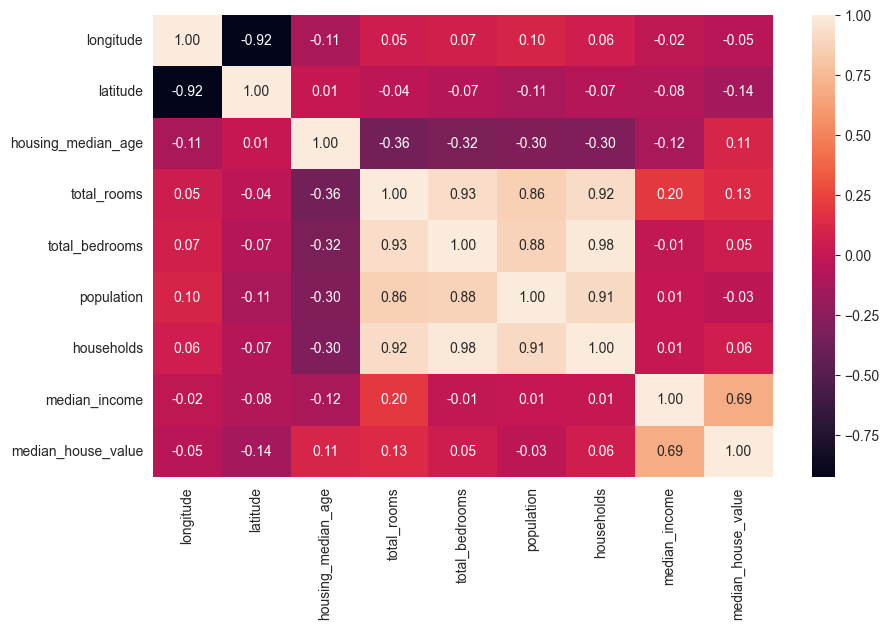

In [246]:
# Check the correlation of dataset between target and features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt='0.2f')

<AxesSubplot: >

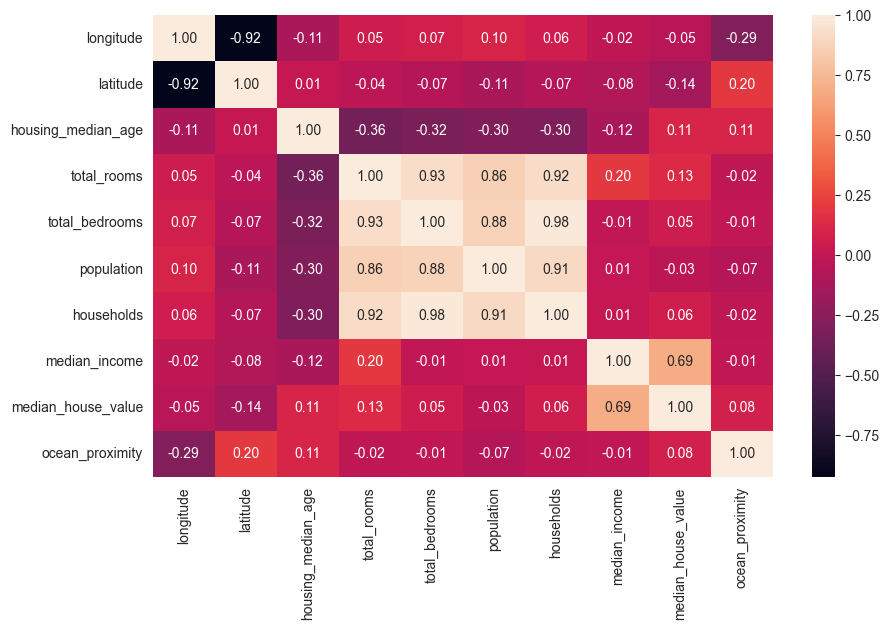

In [247]:
# Check the correlation of dataset between target and features after encoding
plt.figure(figsize=(10, 6))
tmp_encoding_df = df.copy()
tmp_encoding_df = object_encoder(tmp_encoding_df, 'LabelEncoder', ['ocean_proximity'])
sns.heatmap(tmp_encoding_df.corr(), annot=True, fmt='0.2f')

In [ ]:
# Feature type 0

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder', 'OrdinalEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list)

In [ ]:
# Feature type 1
feature_list = ['total_rooms', 'total_bedrooms', 'population', 'households']

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder', 'OrdinalEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 2
feature_list = ['total_rooms', 'total_bedrooms', 'population', 'households', "ocean_proximity"]

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 3
feature_list = ['total_bedrooms', 'population', 'households', "ocean_proximity"]

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Normalizer']
# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 4
feature_list = ['total_bedrooms', 'population', 'households']

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 5
feature_list = ['total_rooms', 'total_bedrooms', 'households']

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 6
feature_list = ['total_bedrooms', 'households']

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 7
feature_list = ['total_rooms', 'median_income']

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 8
feature_list = ['housing_median_age','total_rooms', 'median_income']

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)

In [ ]:
# Feature type 9
feature_list = ['longitude','latitude']

# List setting
model_list = ['kmeans', 'em', 'clarans', 'dbscan', 'meanshift']
encoder_list = ['LabelEncoder']
scaling_list = ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'Normalizer']

# 20,000 datasets are too large to take long to calculate (especially CLARANS)
# So we will randomly extract only 10% of the total dataset and use it.
random_dataset = df.sample(n=int(df.shape[0] * 0.1), random_state=42)

# auto_ml parameters:
#   input_dataset, model_lists, encoder_lists, scaling_lists, select_feature_lists=None, k_lists=None
auto_ml(input_dataset=random_dataset, model_lists=model_list, encoder_lists=encoder_list, scaling_lists=scaling_list,
        select_feature_lists=feature_list)